In [1]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from src.inference import curve_fit_emcee
import src.observing as OBS
import src.map_making as MM

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler


In [14]:
lmax=32
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=nuarr, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=True)
mat_Y = calc_spherical_harmonic_matrix(nside, lmax)

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


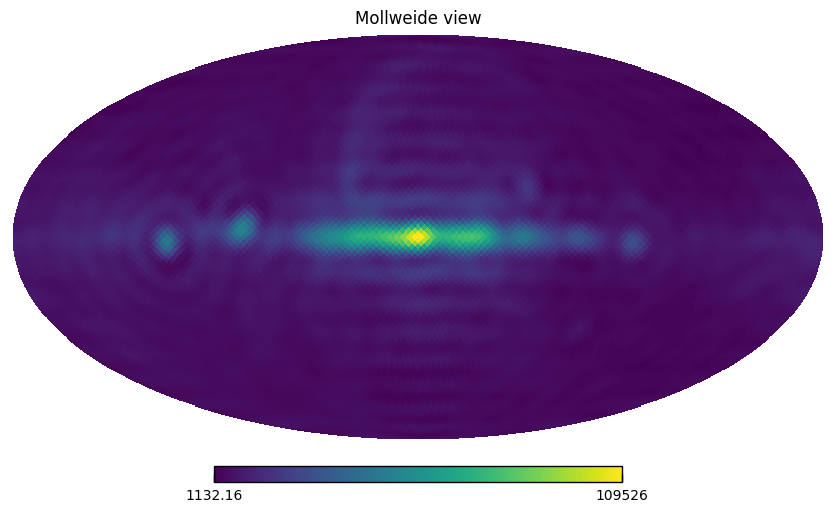

In [3]:
hp.mollview(mat_Y@fg_alm[Nlmax:2*Nlmax])

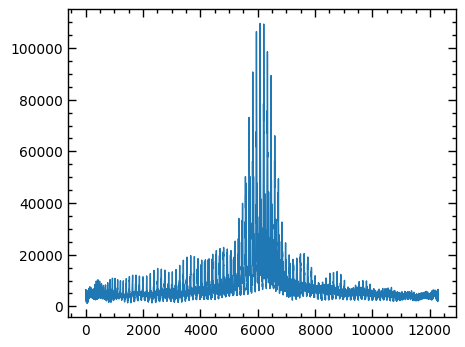

In [4]:
plt.plot(mat_Y@fg_alm[Nlmax:2*Nlmax])

In [15]:
# Load all relevant chromaticity correction data.
corr = np.load('saves/Binwise/chrom_corr.npy')
timestream = np.load('saves/Binwise/dnoisy_vector.npy')
timestream_corr = np.load('saves/Binwise/dnoisy_vector_corr.npy')
timestream_noise = np.load('saves/Binwise/noise.npy')
binned = np.load('saves/Binwise/Nant<7>_Npoly<3>_chrom<1.6e-02>_HS_data.npy')
binnederr = np.load('saves/Binwise/Nant<7>_Npoly<3>_chrom<1.6e-02>_HS_dataerr.npy')
mat_PYB = np.load('saves/Binwise/mat_PYB.npy')
mat_G = np.load('saves/Binwise/mat_G.npy')
alldata = [corr, timestream, timestream_corr, timestream_noise, binned]
for d in alldata:
    print(d.shape)

Nt = int(corr.shape[0]/binned.shape[0])

(4284,)
(4284,)
(4284,)
(4284,)
(51,)


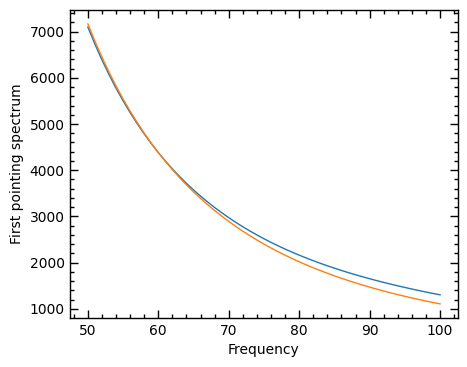

In [6]:
plt.plot(nuarr,timestream[::Nt], label='uncorrected')
plt.plot(nuarr,timestream_corr[::Nt], label='corrected')
plt.ylabel('First pointing spectrum')
plt.xlabel('Frequency')
plt.show()

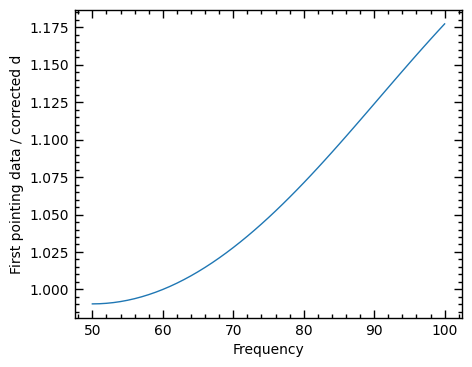

In [7]:
plt.plot(nuarr,timestream[::Nt]/timestream_corr[::Nt])
plt.ylabel('First pointing data / corrected d')
plt.xlabel('Frequency')
plt.show()

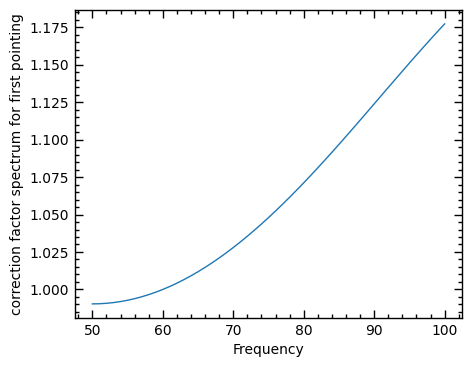

In [8]:
plt.plot(nuarr,corr[::Nt])
plt.ylabel('correction factor spectrum for first pointing')
plt.xlabel('Frequency')
plt.show()

In [9]:
corr_sep = [corr[i::Nt] for i in range(Nt)]

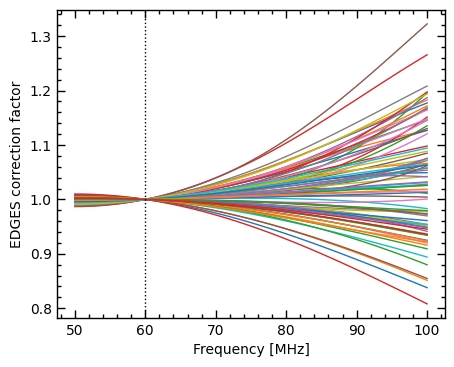

Text(0, 0.5, 'EDGES correction factor')

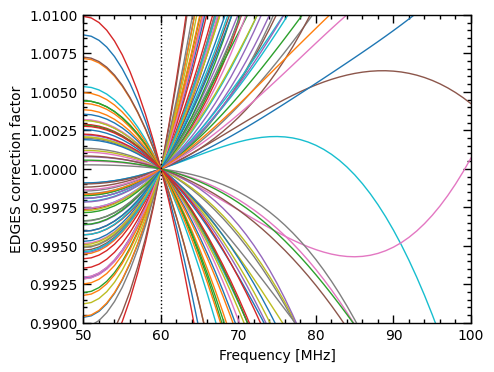

In [19]:
for cfac in corr_sep:
    plt.plot(nuarr, cfac)
plt.axvline(60, linestyle=':', color='k')
plt.xlabel("Frequency [MHz]")
plt.ylabel("EDGES correction factor")
plt.show()
for cfac in corr_sep:
    plt.plot(nuarr, cfac)
plt.ylim(0.99,1.01)
plt.xlim(50,100)
plt.axvline(60, linestyle=':', color='k')
plt.xlabel("Frequency [MHz]")
plt.ylabel("EDGES correction factor")

Initial guess from curve_fit: [ 4.37928019 -2.57575799  0.39617603]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 267.49it/s]


Initial guess from curve_fit: [ 4.37935177e+00 -2.69999343e+00 -1.67104205e-05]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 215.88it/s]


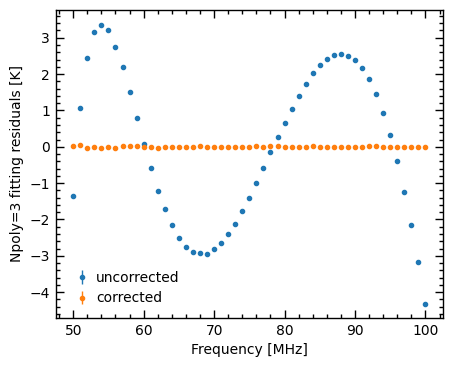

In [11]:
# Fit a polynomial to corrected and uncorrected timeseries data from 
# pointing 1, to see if the chromaticity correction helps at all.
ts_1 = timestream[::Nt]
ts_corr_1 = timestream_corr[::Nt]
sigma_1 = timestream_noise[::Nt]

# First remove the 21-cm global signal from the first pointing.
cm21_temp = SM.cm21_globalT(nuarr, *OBS.cm21_params)
# for the uncorrected data...

ts_fg_1 = ts_1 - cm21_temp
# and for the corrected data...
ts_corr_fg_1 = ts_corr_1 - cm21_temp/corr[0]  # Note: have to normalise the 21-cm signal by the correction.

# Fit polynomials to this.
def fg_polymod(nuarr, *theta_fg):
    Afg, alpha = theta_fg[:2]
    zetas      = theta_fg[2:]
    exponent = [zetas[i]*np.log(nuarr/60)**(i+2) for i in range(len(zetas))]
    fg_a00_terms = (Afg*1e3)*(nuarr/60)**alpha * np.exp(np.sum(exponent, 0))
    return fg_a00_terms + T_CMB

Npoly=3
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res = curve_fit_emcee(fg_polymod, nuarr, ts_fg_1, sigma_1, bounds=bounds, chain=True)

Npoly=3
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res_corr = curve_fit_emcee(fg_polymod, nuarr, ts_corr_fg_1, sigma_1, bounds=bounds, chain=True)

# Examine the residuals of both of these fits.
plt.errorbar(nuarr, ts_fg_1-fg_polymod(nuarr, *res[0]), sigma_1, fmt='.', label='uncorrected')
plt.errorbar(nuarr, ts_corr_fg_1-fg_polymod(nuarr, *res_corr[0]), sigma_1, fmt='.', label='corrected')
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Npoly=3 fitting residuals [K]")
plt.show()

Initial guess from curve_fit: [ 4.37911687 -2.58855585  0.39768878  0.36193909 -0.6609972 ]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 181.07it/s]


Initial guess from curve_fit: [ 4.37934866e+00 -2.69998613e+00  2.82301427e-05 -3.30719064e-04
  4.41181446e-04]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:08<00:00, 146.97it/s]


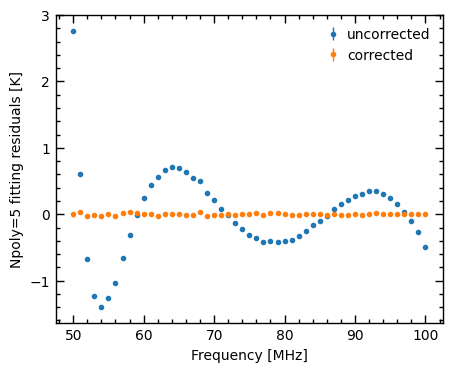

In [12]:
Npoly=5
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res = curve_fit_emcee(fg_polymod, nuarr, ts_fg_1, sigma_1, bounds=bounds, chain=True)

Npoly=5
p0 = [10, -2.5]
p0 += [0.01]*(Npoly-2)
priors = [[1, 25], [-3.5, -1.5]]
priors += [[-10, 10.1]]*(Npoly-2)
bounds = list(zip(*priors))
res_corr = curve_fit_emcee(fg_polymod, nuarr, ts_corr_fg_1, sigma_1, bounds=bounds, chain=True)

# Examine the residuals of both of these fits.
plt.errorbar(nuarr, ts_fg_1-fg_polymod(nuarr, *res[0]), sigma_1, fmt='.', label='uncorrected')
plt.errorbar(nuarr, ts_corr_fg_1-fg_polymod(nuarr, *res_corr[0]), sigma_1, fmt='.', label='corrected')
plt.legend()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Npoly=5 fitting residuals [K]")
plt.show()

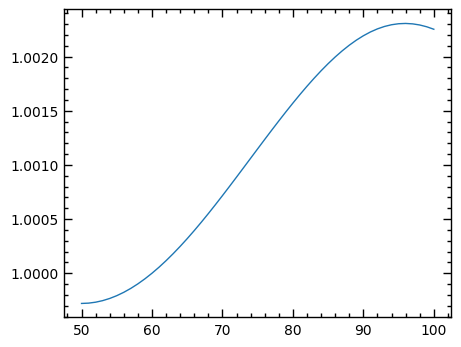

In [20]:
# Investigate whether binning the corrected timestream data will impact the foreground fitting.
binned_timestream = mat_G @ timestream
binned_timestream_corr = mat_G @ timestream_corr
binned_corr = mat_G @ corr

plt.plot(nuarr,binned_timestream/binned_timestream_corr)

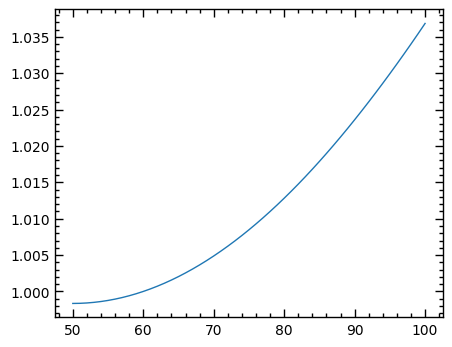

In [21]:
plt.plot(nuarr,binned_corr)

## What is the chrom corr actually doing? Let's see!
Visualise what the chromaticity correction is doing in our data. Observe (with 7 antennas) a fake foreground which has the spatial shape of the true foregrounds at 60 MHz, but also has the temperature of the foregrounds at 60 MHz for all frequencies. Plot this in data space (maybe both seperately AND binned into a single bin in one figure), then recover the alm and show that the monopole is super (hopefully) achromatic.
Acromagic.

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21
successfully loaded spherical_harmonic_matrix npix, nalm : 12288 21


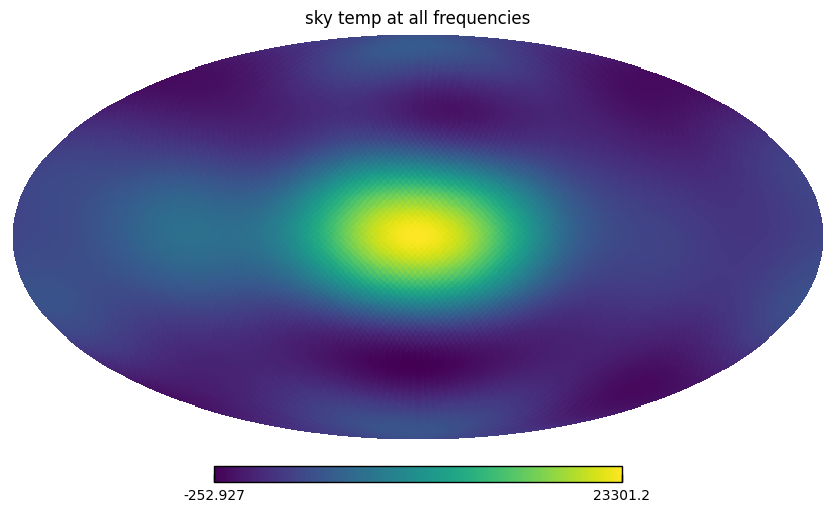

In [107]:
lmax=5
nside=32
Nlmax=RS.get_size(lmax)
fg_alm = SM.foreground_gsma_alm_nsidelo(nu=60, lmax=lmax, nside=nside, use_mat_Y=True, const_idx=True)
mat_Y  = calc_spherical_harmonic_matrix(nside, lmax)
hp.mollview(mat_Y@fg_alm, title='sky temp at all frequencies')

In [53]:
mat_Y_bl  = BlockMatrix(mat_Y, nblock=len(nuarr))
fg_alm_bl = BlockVector(fg_alm, nblock=len(nuarr), mode='block')


In [101]:
def gen_chrom_obs(chrom):
    lats      = np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
    times     = np.linspace(0, 24, 12, endpoint=False)
    chromfunc = partial(BF.fwhm_func_tauscher, c=chrom)
    
    mat_A, (mat_G, mat_P, mat_Y_bl, mat_B) = FM.calc_observation_matrix_multi_zenith_driftscan_chromatic(
        nuarr, nside, lmax, lats=lats, times=times, 
        return_mat=True, beam_use=BF.beam_cos_FWHM, chromaticity=chromfunc
    )
    d = mat_P @ mat_Y_bl @ mat_B @ fg_alm_bl
    cov = np.diag([1.]*len(d.block[0]))
    cov_bl = BlockMatrix(cov, nblock=len(nuarr))
    return d, cov_bl

chrom_list = [0, 1.6e-2, 3.4e-2, 4.5e-2]
ds = []
covs = []
for chrom in chrom_list:
    d, cov = gen_chrom_obs(chrom)
    ds.append(d)
    covs.append(cov)

Text(0, 0.5, 'Binned Temperature [K]')

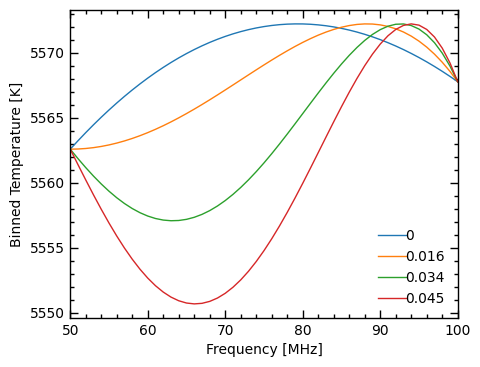

In [102]:
# Visualise the data.
for d, chrom in zip(ds, chrom_list):
    d_tot = np.zeros_like(d[0])
    for i in range(len(nuarr)):
        d_tot += d[i]
    plt.plot(nuarr, d_tot/len(nuarr), label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Binned Temperature [K]")

In [103]:
# Estimate the alm from the data.
alm_ests = []
for d, cov_bl in zip(ds, covs):
    mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_P@mat_Y_bl@mat_B, mat_N=cov_bl, cond=True)
    alm_est = mat_W @ d
    alm_ests.append(alm_est)

1/condition #: 4.454047939606732e-07
1/condition #: 4.454047939606732e-07
1/condition #: 4.454047939606732e-07
1/condition #: 4.454047939606732e-07


Text(0, 0.5, 'Monopole temperature estimates [K]')

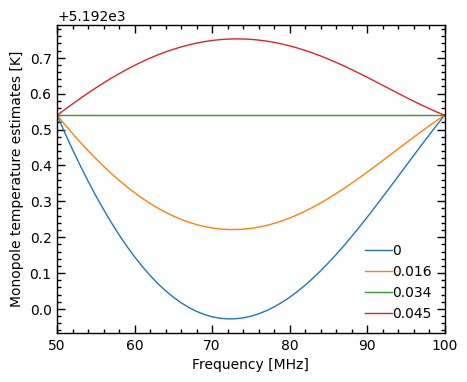

In [105]:
# Visualise the data.
for alm_est, chrom in zip(alm_ests, chrom_list):
    plt.plot(nuarr, alm_est[0]*alm2temp, label=chrom)
plt.legend()
plt.xlim(50,100)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Monopole temperature estimates [K]")

In [59]:
# Estimate the alm from the data.
cov     = np.diag([1.]*len(d.block[0]))
cov_bl  = BlockMatrix(cov, nblock=len(nuarr))
mat_W   = MM.calc_ml_estimator_matrix(mat_A=mat_P@mat_Y_bl@mat_B, mat_N=cov_bl, cond=True)
alm_est = mat_W @ d

1/condition #: 4.454047939606732e-07


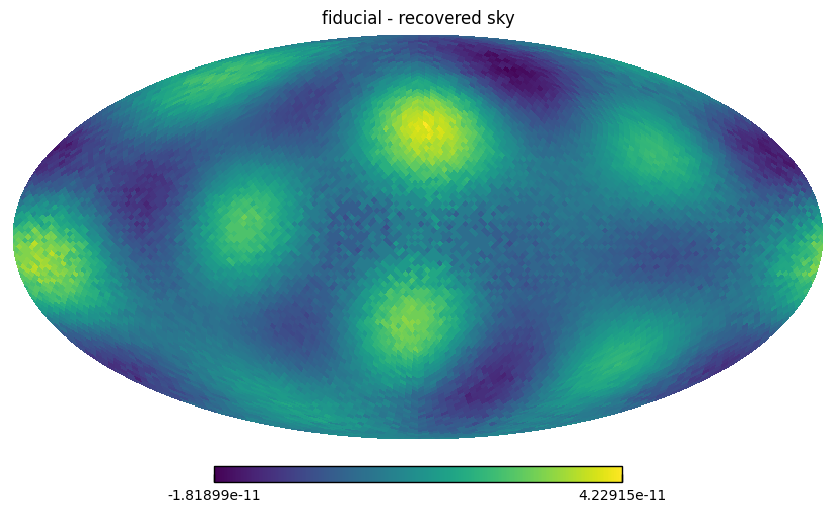

In [64]:
hp.mollview(mat_Y@fg_alm-mat_Y@alm_est.block[0], title='fiducial - recovered sky')

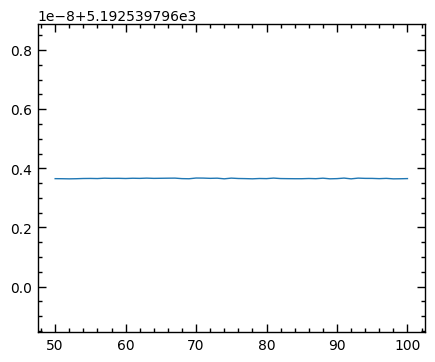

In [68]:
alm2temp = 1/np.sqrt(4*np.pi)
plt.plot(nuarr, alm_est[0]*alm2temp)